- BERT4Recに変更

In [1]:
import sys

sys.path.append("..")

In [2]:
import random

import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib

from src.util import *
from src.model import *

tqdm.pandas()

In [3]:
last_review_date = pd.to_datetime("2015/01/01")
train_split_date = pd.to_datetime("2017/01/01")
test_split_date = pd.to_datetime("2018/01/01")

MASK_TOKEN = "[mask]"

seed = 0
random.seed(seed)
np.random.seed(seed)

In [4]:
interaction_df, user_le, item_le = load_interaction_df(
    last_review_date=last_review_date,
    train_split_date=train_split_date,
)
items = item_le.transform(item_le.classes_)

(
    train_dataset,
    test_dataset,
    train_user_feature_table,
    test_user_feature_table,
    train_negative_sampler,
    test_negative_sampler,
) = create_dataset(
    interaction_df=interaction_df,
    train_split_date=train_split_date,
    test_split_date=test_split_date,
)

100%|██████████| 25093/25093 [00:00<00:00, 157808.70it/s]


In [5]:
class Model4(torch.nn.Module):
    def __init__(
        self,
        item_size: int,
        user_feature_dim: int,
        num_layers: int = 4,
        d_model: int = 64,
        dim_feedforward: int = 128,
        nhead: int = 4,
    ) -> None:
        super().__init__()
        self.user_embedding = torch.nn.Linear(user_feature_dim, d_model)
        self.item_embedding = torch.nn.Embedding(item_size, d_model)

        self.positional_encoding = PositionalEncoding(d_model=d_model)
        self.transformer_layer = torch.nn.TransformerEncoder(
            encoder_layer=torch.nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                batch_first=True,
            ),
            num_layers=num_layers,
        )
        self.clv_layer = TwoFeedForwardLayer(d_model, d_model // 2, 1)
        self.target_layer = TwoFeedForwardLayer(d_model, d_model * 2, d_model)

    def forward(
        self,
        user_features: torch.Tensor,
        item_indices: torch.Tensor,
        target_indices: torch.Tensor,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        e_u = self.user_embedding.forward(user_features)
        e_v = self.item_embedding.forward(item_indices)
        e_v = self.positional_encoding.forward(e_v)
        H = torch.cat((e_u.unsqueeze(1), e_v), dim=1)
        H = self.transformer_layer.forward(H)

        y_clv = torch.sigmoid(self.clv_layer.forward(H[:, 0]))
        H_v = self.target_layer.forward(H[:, -1])

        e_target = self.item_embedding.forward(target_indices)
        v_target = torch.matmul(H_v.unsqueeze(1), e_target.mT)
        y_target = torch.sigmoid(v_target)

        return y_clv.squeeze(), y_target.squeeze()

In [32]:
def run_one_epoch(
    model: Model4,
    dataloader: torch.utils.data.DataLoader,
    user_feature_table: np.ndarray,
    negative_sampler: NegativeSampler,
    optimizer: torch.optim.Optimizer,
    args: Args,
    items: list[int],
    is_eval: bool = False,
) -> dict:
    result: dict[str, dict] = {
        "target": {"loss": 0.0, "y_pred": [], "y_true": []},
        "clv": {"loss": 0.0, "y_pred": [], "y_true": []},
    }

    if is_eval:
        model.eval()
    else:
        model.train()

    for batch in tqdm(dataloader):
        user_ids = []
        item_indices = []
        target_indices = []
        target_labels = []
        clv_labels = []

        for user_id, user_context_items, target_items, clv in batch:
            if len(target_items) == 0:
                continue
            for _ in range(args.sample_size):
                context_item_indices = []
                for _ in range(args.context_item_size):
                    context_item_indices.append(
                        random.randrange(len(user_context_items))
                    )
                context_item_indices.sort()
                context_items = [user_context_items[i] for i in context_item_indices]

                user_ids.append(user_id)
                item_indices.append(context_items)
                clv_labels.append(clv)
                target_indices.append([])
                target_labels.append([])

                # 正例
                target_indices[-1].extend(target_items)
                target_labels[-1].extend([1] * len(target_items))

                # 負例
                negative_sample_size = args.negative_sample_size * len(target_items)
                negative_sample = negative_sampler.sample(negative_sample_size)
                target_indices[-1].extend(negative_sample.tolist())
                target_labels[-1].extend([0] * negative_sample_size)

        user_features = torch.FloatTensor(user_feature_table[user_ids]).to(args.device)
        item_indices = torch.LongTensor(item_indices).to(args.device)
        target_indices = torch.LongTensor(target_indices).to(args.device)
        target_labels = torch.FloatTensor(target_labels).to(args.device).flatten()
        clv_labels = torch.FloatTensor(clv_labels).to(args.device).flatten()

        y_clv, y_target = model.forward(user_features, item_indices, target_indices)
        y_clv = y_clv.flatten()
        y_target = y_target.flatten()

        print(y_target.shape, target_labels.shape, target_indices.shape)
        target_loss = torch.nn.functional.binary_cross_entropy(y_target, target_labels)
        clv_loss = torch.nn.functional.binary_cross_entropy(y_clv, clv_labels)
        loss = target_loss * args.alpha + clv_loss * (1 - args.alpha)

        if not is_eval:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        result["target"]["loss"] += target_loss.item()
        result["target"]["y_pred"].extend(y_target.tolist())
        result["target"]["y_true"].extend(target_labels.tolist())
        result["clv"]["loss"] += clv_loss.item()
        result["clv"]["y_pred"].extend(y_clv.tolist())
        result["clv"]["y_true"].extend(clv_labels.tolist())

    for term_name in result.keys():
        result[term_name]["loss"] /= len(dataloader)

    return result


def train(
    model: Model4,
    train_dataset: Dataset,
    test_dataset: Dataset,
    train_user_feature_table: np.ndarray,
    test_user_feature_table: np.ndarray,
    train_negative_sampler: NegativeSampler,
    test_negative_sampler: NegativeSampler,
    args: Args,
    items: list[int],
) -> tuple[list[dict], list[dict]]:
    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=args.batch_size,
        shuffle=True,
        collate_fn=lambda x: x,  # 各データは形式が異なるため、バッチ化せずにそのまま返す
    )
    test_dataloader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        collate_fn=lambda x: x,  # 各データは形式が異なるため、バッチ化せずにそのまま返す
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

    train_results = []
    test_results = []

    for epoch in range(args.epochs):
        print(f"[epoch: {epoch + 1}/{args.epochs}]")
        train_result = run_one_epoch(
            model=model,
            dataloader=train_dataloader,
            user_feature_table=train_user_feature_table,
            negative_sampler=train_negative_sampler,
            optimizer=optimizer,
            args=args,
            items=items,
        )
        print(
            f"[train][loss] target_loss: {train_result['target']['loss']:.6f}, clv_loss: {train_result['clv']['loss']:.6f}"
        )
        train_results.append(train_result)

        test_result = run_one_epoch(
            model=model,
            dataloader=test_dataloader,
            user_feature_table=test_user_feature_table,
            negative_sampler=test_negative_sampler,
            optimizer=optimizer,
            args=args,
            items=items,
            is_eval=True,
        )
        print(
            f"[test][loss] target_loss: {test_result['target']['loss']:.6f}, clv_loss: {test_result['clv']['loss']:.6f}"
        )
        test_results.append(test_result)

    return train_results, test_results

In [33]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

target_loss_weight = 1
clv_loss_weight = 1
alpha = target_loss_weight / (target_loss_weight + clv_loss_weight)

args = Args(
    d_model=32,
    dim_feedforward=64,
    batch_size=64,
    nhead=4,
    num_layers=4,
    epochs=10,
    lr=1e-3,
    sample_size=5,
    negative_sample_size=100,
    alpha=alpha,
    context_item_size=10,
    device=device,
    model_path="model4.model",
)

try:
    model = torch.load(args.model_path)
    print(f"loaded model from: {args.model_path}")
except FileNotFoundError:
    model = Model4(
        item_size=len(items),
        user_feature_dim=train_user_feature_table.shape[1],
        d_model=args.d_model,
        dim_feedforward=args.dim_feedforward,
        nhead=args.nhead,
        num_layers=args.num_layers,
    )
model.to(args.device)
model.train()

print(f"args: {args}")
train_results, test_results = train(
    model=model,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    train_user_feature_table=train_user_feature_table,
    test_user_feature_table=test_user_feature_table,
    train_negative_sampler=train_negative_sampler,
    test_negative_sampler=test_negative_sampler,
    args=args,
    items=items,
)

torch.save(model, args.model_path)
print(f"saved model to: {args.model_path}")

args: Args(d_model=32, dim_feedforward=64, batch_size=64, nhead=4, num_layers=4, epochs=10, lr=0.001, sample_size=5, negative_sample_size=100, alpha=0.5, context_item_size=10, device='mps', model_path='model4.model')
[epoch: 1/10]


  0%|          | 0/393 [00:00<?, ?it/s]

(800,)
(800,)
(800,)
(800,)
(800,)
(5700,)
(5700,)
(5700,)
(5700,)
(5700,)
(3100,)
(3100,)
(3100,)
(3100,)
(3100,)
(8900,)
(8900,)
(8900,)
(8900,)
(8900,)
(4800,)
(4800,)
(4800,)
(4800,)
(4800,)
(22600,)
(22600,)
(22600,)
(22600,)
(22600,)
(500,)
(500,)
(500,)
(500,)
(500,)
(900,)
(900,)
(900,)
(900,)
(900,)
(14700,)
(14700,)
(14700,)
(14700,)
(14700,)
(1200,)
(1200,)
(1200,)
(1200,)
(1200,)
(900,)
(900,)
(900,)
(900,)
(900,)


ValueError: expected sequence of length 808 at dim 1 (got 5757)

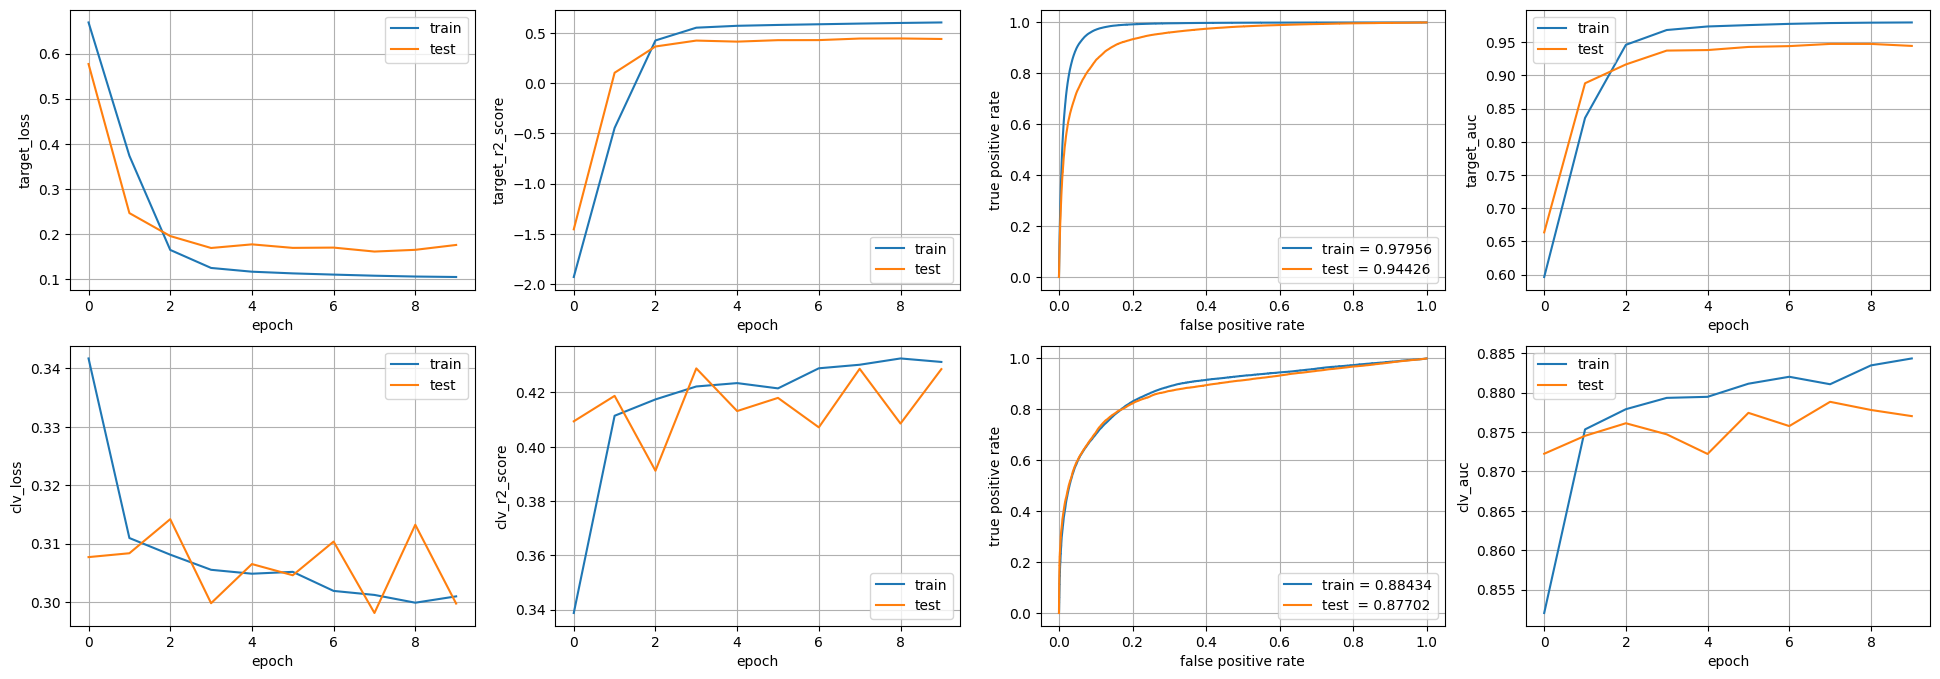

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(24, 8))
loss_names = ["target", "clv"]

for i, loss_name in enumerate(loss_names):
    plot_loss(train_results, test_results, loss_name, axes[i, 0])
    plot_r2_score(train_results, test_results, loss_name, axes[i, 1])
    plot_roc_auc(train_results[-1], test_results[-1], loss_name, axes[i, 2])
    plot_auc(train_results, test_results, loss_name, axes[i, 3])

plt.show()

In [ ]:
for user_id, user_context_items, target_items, clv in tqdm(train_dataset):
    if len(target_items) == 0:
        continue
    user_ids = []
    item_indices = []
    for _ in range(2):
        context_item_indices = []
        for _ in range(args.context_item_size):
            context_item_indices.append(random.randrange(len(user_context_items)))
        context_item_indices.sort()
        context_items = [user_context_items[i] for i in context_item_indices]

        user_ids.append(user_id)
        item_indices.append(context_items)

    user_features = torch.FloatTensor(test_user_feature_table[user_ids]).to(args.device)
    item_indices = torch.LongTensor(item_indices).to(args.device)
    target_indices = torch.LongTensor(items).to(args.device)

    with torch.no_grad():
        e_u = model.user_embedding.forward(user_features)
        e_v = model.item_embedding.forward(item_indices)
        e_v = model.positional_encoding.forward(e_v)
        H = torch.cat((e_u.unsqueeze(1), e_v), dim=1)
        H = model.transformer_layer.forward(H)

        y_clv = torch.sigmoid(model.clv_layer.forward(H[:, 0]))
        H_v = model.target_layer.forward(H[:, -1])

        e_target = model.item_embedding.forward(target_indices)
        v_target = torch.matmul(H_v.unsqueeze(1), e_target.mT)
        y_target = torch.sigmoid(v_target)
        # print(H.shape, H)
        x = H[:, -1]
        # print("1:", x)
        x = model.target_layer.fc1.forward(x)
        # print("2:", x)
        x = torch.nn.functional.leaky_relu(x)
        # print("3:", x)
        x = model.target_layer.fc2.forward(x)
        # print("4:", x)
        # print("b:", model.target_layer.fc2.bias)
        # print(H_v)
        # print(e_target)
        # print(v_target)
        print(y_target[0][0][:7])

In [ ]:
model.eval()

before_rerank_size = 50
filter_sample_size = 10
rerank_sample_size = 10
top_k = 10

total_count = 0
before_hit_count = 0
after_hit_count = 0

recommendations = {}

for user_id, user_context_items, target_items, clv in tqdm(train_dataset):
    if len(target_items) == 0:
        continue
    total_count += 1

    recommendations[user_id] = {}

    user_ids = []
    item_indices = []
    for _ in range(filter_sample_size):
        context_item_indices = []
        for _ in range(args.context_item_size):
            context_item_indices.append(random.randrange(len(user_context_items)))
        context_item_indices.sort()
        context_items = [user_context_items[i] for i in context_item_indices]
        user_ids.append(user_id)
        item_indices.append(context_items)

    user_features = torch.FloatTensor(test_user_feature_table[user_ids]).to(args.device)
    item_indices = torch.LongTensor(item_indices).to(args.device)
    target_indices = torch.LongTensor(items).to(args.device)

    with torch.no_grad():
        _, y_target = model.forward(
            user_features, item_indices, target_indices=target_indices
        )

    b = y_target.mean(dim=0).cpu().detach().numpy()

    before_rerank_rec = items[np.argsort(b)][::-1][
        :before_rerank_size
    ]  # 降順でソートし、上位`before_rerank_size`件を取得する

    hit = len(set(before_rerank_rec[:top_k]) & set(target_items))
    # print("before rerank:", hit, "/", len(target_items))
    if hit > 0:
        before_hit_count += 1

    clv_mean = []
    user_ids = []
    item_indices = []
    for target_item in before_rerank_rec:
        for _ in range(rerank_sample_size):
            context_item_indices = []
            for _ in range(args.context_item_size):
                context_item_indices.append(random.randrange(len(user_context_items)))
            context_item_indices.sort()
            context_items = [user_context_items[i] for i in context_item_indices]

            v = list(context_items)
            v.append(target_item)
            user_ids.append(user_id)
            item_indices.append(v)

    user_features = torch.FloatTensor(test_user_feature_table[user_ids]).to(args.device)
    item_indices = torch.LongTensor(item_indices).to(args.device)
    target_indices = torch.LongTensor([0]).to(args.device)  # CLVのみを計算するので、ダミーを入れておく

    with torch.no_grad():
        y_clv, _ = model.forward(user_features, item_indices, target_indices)

    y_clv = y_clv.cpu().detach().numpy()
    clv_mean = np.add.reduceat(y_clv, np.arange(0, y_clv.shape[0], rerank_sample_size))

    after_rerank_rec = before_rerank_rec[np.argsort(clv_mean)][::-1]

    hit = len(set(after_rerank_rec[:top_k]) & set(target_items))

    # print("after rerank:", hit, "/", len(target_items))
    if hit > 0:
        after_hit_count += 1

    recommendations[user_id]["target_items"] = item_le.inverse_transform(
        target_items
    ).tolist()
    recommendations[user_id]["before_rerank_rec"] = item_le.inverse_transform(
        before_rerank_rec
    ).tolist()
    recommendations[user_id]["before_rerank_rec_value"] = b[before_rerank_rec].tolist()
    recommendations[user_id]["after_rerank_rec"] = item_le.inverse_transform(
        after_rerank_rec
    ).tolist()
    recommendations[user_id]["after_rerank_rec_value"] = b[after_rerank_rec].tolist()


print(f"before hit-ratio:  {before_hit_count / total_count:.5f}")
print(f"after hit-ratio:   {after_hit_count / total_count:.5f}")

100%|██████████| 25093/25093 [03:55<00:00, 106.40it/s]

before hit-ratio:  0.63090
after hit-ratio:   0.51563


In [ ]:
rec_df = pd.DataFrame.from_dict(recommendations, orient="index")
rec_df.index = rec_df.index.rename("user_id")
rec_df.to_csv("../out/rec8.csv")

In [ ]:
print(sorted(rec_df.before_rerank_rec_value.iloc[0], reverse=True))
print(sorted(rec_df.before_rerank_rec_value.iloc[1], reverse=True))

[0.9956567883491516, 0.9806453585624695, 0.9795746803283691, 0.9762765765190125, 0.9682609438896179, 0.9668537378311157, 0.9644695520401001, 0.9592563509941101, 0.947653591632843, 0.9445328116416931, 0.9441224932670593, 0.9412515759468079, 0.9402101635932922, 0.9396970868110657, 0.9376716613769531, 0.9368287920951843, 0.9346016049385071, 0.9345181584358215, 0.9328727126121521, 0.932559609413147, 0.9323291778564453, 0.9306287169456482, 0.9295879602432251, 0.9200443625450134, 0.918958842754364, 0.9178261160850525, 0.9177438020706177, 0.9172148108482361, 0.9159069061279297, 0.91292804479599, 0.9122264981269836, 0.9116663932800293, 0.9110004305839539, 0.9108490347862244, 0.9107282757759094, 0.9104852676391602, 0.910403847694397, 0.9096506237983704, 0.9095926284790039, 0.9057933688163757, 0.9057783484458923, 0.9049334526062012, 0.9031335711479187, 0.9019554257392883, 0.9018646478652954, 0.9002979397773743, 0.8993213772773743, 0.8984493613243103, 0.8984178900718689, 0.8979911804199219]
[0.99